In [1]:
%matplotlib inline
# %matplotlib ipympl
#
import sys; sys.path.insert(0, "..")
from multifunbrain import *
#
from nilearn import datasets, plotting, image
from nilearn.datasets import load_mni152_template
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm

#
path_root = Path.cwd().parent
path_data =  path_root / Path("data")
#
os.chdir(path_root)
flag_path = True
print(os.getcwd())

/home/opisthofulax/Documents/UniPa/projects/multifun-brain


[get_dataset_dir] Dataset found in /home/opisthofulax/Documents/UniPa/projects/multifun-brain/data/fsl


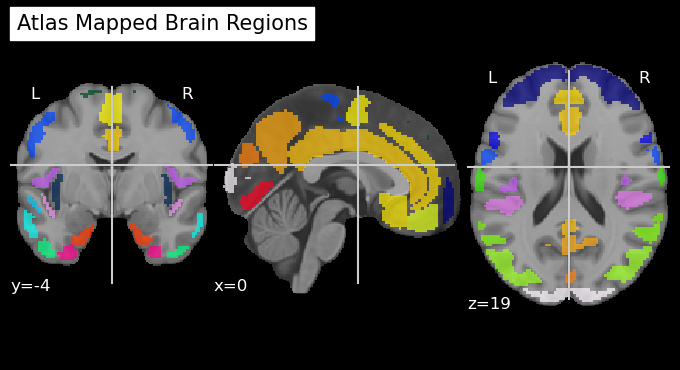

In [2]:
# Fetch the Harvard-Oxford cortical atlas.
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm', data_dir=path_data)
atlas_filename = atlas.maps
rois = atlas.labels
rois_index = {i: ll for i,ll in enumerate(rois[1:])}

# Load MNI152 template for the background.
template = load_mni152_template()

# Plot the atlas regions on the anatomical background.
plotting.plot_roi(atlas_filename, bg_img=template, title='Atlas Mapped Brain Regions')
plotting.show()

In [3]:
roi_indices = np.unique(list(rois_index.keys()))

atlas_img = image.load_img(atlas_filename)
atlas_data = atlas_img.get_fdata()
#

cmap_temp = plt.get_cmap('tab20')
custom_colors = [cmap_temp(i) for i in range(len(roi_indices))]

# Include a color for the background (assumed label 0)
cmap = ListedColormap(custom_colors)


In [ ]:
ts = np.loadtxt(path_data / "HarvardOxford_48Parcels.ts.1D").T
G, remnodes = build_correlation_network(ts)

/home/opisthofulax/anaconda3/envs/multifun-brain/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/opisthofulax/anaconda3/envs/multifun-brain/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


/tmp/ipykernel_7662/2662854412.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


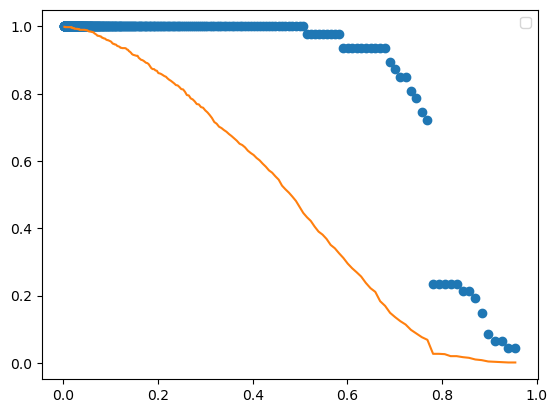

In [19]:
Th, Einf, Pinf = compute_threshold_stats(G)
#
plt.plot(Th, Pinf, 'o')
plt.plot(Th, Einf)
plt.legend()
plt.show()

In [33]:
G, remnodes = build_correlation_network(ts, threshold=0.68)
print(remnodes)
L = nx.laplacian_matrix(G).todense()
spectrum = nx.laplacian_spectrum(G)
rho_m = lambda tau: rho_matrix(tau, L)
Sm1, Csp, VarL, t = entropy(spectrum, steps=600, t1=-2, t2=5)
dists = symmetrized_inverse_distance(1/max(spectrum), rho_m)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
threshold = 1e-8
optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

[9, 34, 37, 33]


/home/opisthofulax/anaconda3/envs/multifun-brain/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/opisthofulax/anaconda3/envs/multifun-brain/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


In [34]:
len(label_list), len(linkage_matrix)

(44, 43)

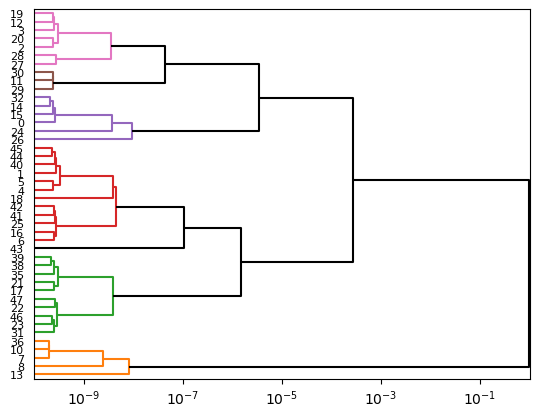

In [35]:
dendro = dendrogram(linkage_matrix, color_threshold=threshold,
                        above_threshold_color='k',
                        orientation='right', labels=label_list)
plt.xscale('log')
plt.xlim(tmin)
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[label] for _,label in enumerate(label_list)]

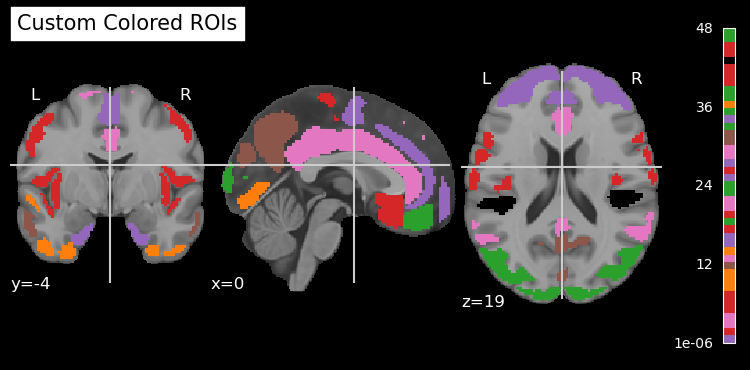

In [42]:
all_colors = node_colors[:]
cmap = ListedColormap(all_colors)
plotting.plot_stat_map(
    atlas_img,
    bg_img=template,
    cmap=cmap,
    title='Custom Colored ROIs'
)
plotting.show()